# cfDNA mixtures series on single chrom

In [1]:
# Imports

%load_ext autoreload
%autoreload 2

import io
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pysam
import warnings
from sklearn.metrics import precision_recall_curve, f1_score, average_precision_score
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix

# set working directory
if not os.getcwd().endswith('cfdna_snv_benchmark'):
    os.chdir('../')
print('Current working directory: {}'.format(os.getcwd()))

from utils.config import Config
from utils.viz import *
from utils.table import *
from utils.metrics import *
from utils.calltable import *
from utils.venn import venn6, get_labels

Current working directory: /Users/hanae/Repositories/cfdna_snv_benchmark


In [2]:
# Config and Display paramaters

config = Config("config/", "config_viz.yaml")
set_display_params(config)
print(config.methods)

paper
['freebayes', 'mutect2', 'strelka2', 'vardict', 'varscan', 'abemus', 'sinvict', 'cfsnv']


In [3]:
# Chomosome

chrom = '22'
muttype = 'snv'
mixtureid =  'CRC-1014_180816-CW-T_CRC-1014_090516-CW-T'
#mixtureid = 'CRC-986_100215-CW-T_CRC-986_300316-CW-T'
#mixtureid =  'CRC-123_310715-CW-T_CRC-123_121115-CW-T'
plasmasample = '_'.join(mixtureid.split('_')[:2])
print(plasmasample)
healthysample = '_'.join(mixtureid.split('_')[2:])
print(healthysample)

CRC-1014_180816-CW-T
CRC-1014_090516-CW-T


In [4]:
reload = False
save = False
fixedvar = 'coverage'
filterparam = 'all'

# Load call table

In [5]:
# Save table if do not exist and load tables

calltables = {'sampleid':[], 'tf':[], 'cov':[], 'snv':[], 'indel':[], 'snp':[]}
mixturefolder = os.path.join(*config.mixturefolder, 'mixtures_chr'+chrom, 'mixtures_chr'+chrom+'_'+mixtureid)
for mixturepath in [l for l in os.listdir(mixturefolder) if l.endswith('x') or l.endswith('T')]:
    print(mixturepath)
    if not os.path.exists(os.path.join(mixturefolder, mixturepath, 'calls', mixturepath+'_snv_calls_'+filterparam+'.csv')) or reload:
        calltable_snv, calltable_indel, calltable_snp = get_calltable(os.path.join(mixturefolder, mixturepath), config.methods, save=True, filter=filterparam)
    calltables['sampleid'].append(mixturepath)
    calltables['tf'].append(np.round(100*float(pd.read_csv(os.path.join(mixturefolder, mixturepath, 'estimated_tf_chr'+chrom+mixturepath[len(('mixture_chr'+chrom)):]+'.txt')).columns[0]), 4))
    calltables['cov'].append(np.round(float(pd.read_csv(os.path.join(mixturefolder, mixturepath, 'coverage_chr'+chrom+mixturepath[len(('mixture_chr'+chrom)):]+'.txt')).columns[0]), 4))
    calltable_snv = pd.read_csv(os.path.join(mixturefolder, mixturepath, 'calls', mixturepath+'_snv_calls_'+filterparam+'.csv'), index_col=0)
    calltable_indel = pd.read_csv(os.path.join(mixturefolder, mixturepath, 'calls', mixturepath+'_indel_calls_'+filterparam+'.csv'), index_col=0)
    calltable_snp = pd.read_csv(os.path.join(mixturefolder, mixturepath, 'calls', mixturepath+'_snp_calls_'+filterparam+'.csv'), index_col=0)
    calltables['snv'].append(calltable_snv)
    calltables['indel'].append(calltable_indel)
    calltables['snp'].append(calltable_snp)
calltables.keys()

mixture_chr22_CRC-1014_180816-CW-T_70x_CRC-1014_090516-CW-T_30x
mixture_chr22_CRC-1014_180816-CW-T_30x_CRC-1014_090516-CW-T_120x
mixture_chr22_CRC-1014_180816-CW-T_10x_CRC-1014_090516-CW-T_140x
mixture_chr22_CRC-1014_180816-CW-T_70x_CRC-1014_090516-CW-T_180x
mixture_chr22_CRC-1014_180816-CW-T_50x_CRC-1014_090516-CW-T_100x
mixture_chr22_CRC-1014_180816-CW-T_70x_CRC-1014_090516-CW-T_0x
mixture_chr22_CRC-1014_180816-CW-T_20x_CRC-1014_090516-CW-T_130x
mixture_chr22_CRC-1014_180816-CW-T_70x_CRC-1014_090516-CW-T_130x
mixture_chr22_CRC-1014_180816-CW-T_5x_CRC-1014_090516-CW-T_145x
mixture_chr22_CRC-1014_180816-CW-T_70x_CRC-1014_090516-CW-T_80x


dict_keys(['sampleid', 'tf', 'cov', 'snv', 'indel', 'snp'])

In [6]:
for mt in ['snv', 'indel', 'snp']:
    if not os.path.exists(os.path.join(mixturefolder, 'calls')):
        os.mkdir(os.path.join(mixturefolder, 'calls'))
    if not os.path.exists(os.path.join(mixturefolder, 'calls', mixtureid+'_'+mt+'_calls_'+filterparam+'.csv')) or reload:
        for ci, csnv in enumerate(calltables[mt]):
            cols = ['chrom', 'pos', 'ref', 'alt', 'type']
            for m in config.methods:
                cols.append('{:.2f}_{}'.format(calltables['tf'][ci], m))
                cols.append('{:.2f}_{}_score'.format(calltables['tf'][ci], m))
            for m in config.methods:
                cols.append('{:.2f}_{}_altcov'.format(calltables['tf'][ci], m)) 
                cols.append('{:.2f}_{}_totcov'.format(calltables['tf'][ci], m)) 
                cols.append('{:.2f}_{}_vaf'.format(calltables['tf'][ci], m)) 
            csnv.columns = cols
        # ensure no duplicated index
        print(calltables[mt][0].loc[calltables[mt][0].index[calltables[mt][0].index.duplicated(keep=False)]].shape[0])
        # get call series
        calltablesseries = pd.concat([ct.set_index(['chrom', 'pos', 'ref', 'alt', 'type']) for ct in calltables[mt]], axis=1)
        calltablesseries.reset_index(inplace=True)
        calltablesseries['chrom_pos_ref_alt'] = calltablesseries['chrom'].astype('str').str.cat(calltablesseries['pos'].astype('str'), sep="_").str.cat(calltablesseries['ref'].astype('str'), sep='_').str.cat(calltablesseries['alt'].astype('str'), sep='_')
        calltablesseries.set_index('chrom_pos_ref_alt', inplace=True)
        print(calltablesseries.shape)
        calltablesseries.to_csv(os.path.join(mixturefolder, 'calls', mixtureid+'_'+mt+'_calls_'+filterparam+'.csv'))
        
calltablesseries = pd.read_csv(os.path.join(mixturefolder, 'calls', mixtureid+'_'+muttype+'_calls_'+filterparam+'.csv'), index_col=0)
calltablesseries.head()

,chrom,pos,ref,alt,type,30.63_freebayes,30.63_freebayes_score,30.63_mutect2,30.63_mutect2_score,30.63_strelka2,...,19.84_varscan_vaf,19.84_abemus_altcov,19.84_abemus_totcov,19.84_abemus_vaf,19.84_sinvict_altcov,19.84_sinvict_totcov,19.84_sinvict_vaf,19.84_cfsnv_altcov,19.84_cfsnv_totcov,19.84_cfsnv_vaf
chrom_pos_ref_alt,,,,,,,,,,,,,,,,,,,,,
22_16050159_C_T,22,16050159,C,T,SNV,False,NaN,False,NaN,False,...,NaN,NaN,NaN,NaN,39.0,339.0,0.115044,NaN,NaN,NaN
22_16050252_A_T,22,16050252,A,T,SNV,False,NaN,False,NaN,False,...,NaN,NaN,NaN,NaN,53.0,379.0,0.139842,NaN,NaN,NaN
22_16050408_T_C,22,16050408,T,C,SNV,False,NaN,False,NaN,False,...,NaN,NaN,NaN,NaN,26.0,245.0,0.106122,NaN,NaN,NaN
22_16050455_T_C,22,16050455,T,C,SNV,False,NaN,False,NaN,False,...,NaN,NaN,NaN,NaN,31.0,193.0,0.160622,NaN,NaN,NaN
22_16050612_C_G,22,16050612,C,G,SNV,False,NaN,False,NaN,False,...,NaN,NaN,NaN,NaN,107.0,281.0,0.380783,NaN,NaN,NaN


In [7]:
print(calltables['tf'])
print(len(list(calltablesseries.columns)))
print(len(np.unique(list(calltablesseries.columns))))

[30.6268, 9.09, 3.0294, 12.9234, 15.1505, 45.45, 6.059, 14.674, 1.5137, 19.8415]
405
405


# Generate ground truth

## Approach 1: consensus 

['freebayes', 'mutect2', 'strelka2', 'vardict', 'varscan', 'abemus', 'sinvict', 'cfsnv']
45.45_freebayes      454
45.45_mutect2       1018
45.45_strelka2       619
45.45_vardict        418
45.45_varscan       2449
45.45_abemus       22659
45.45_sinvict      30389
45.45_cfsnv          172
dtype: object


False    148954
True         99
Name: truth, dtype: int64

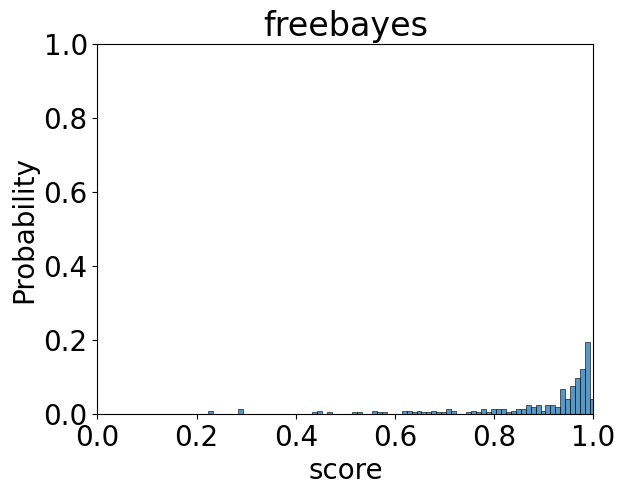

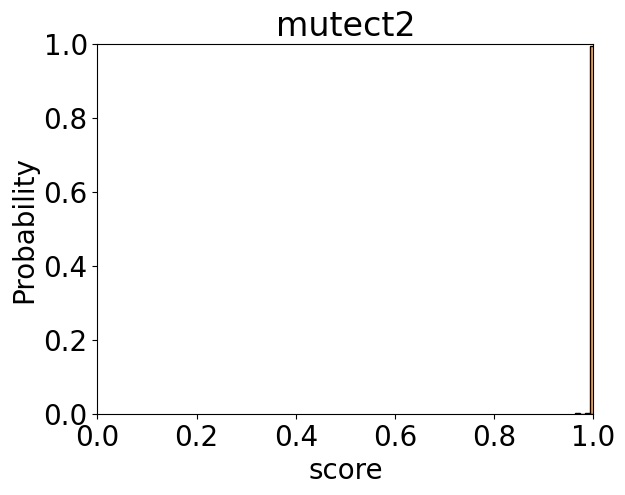

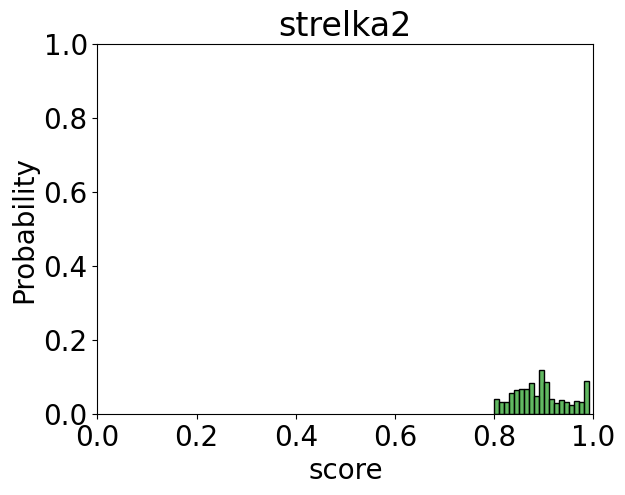

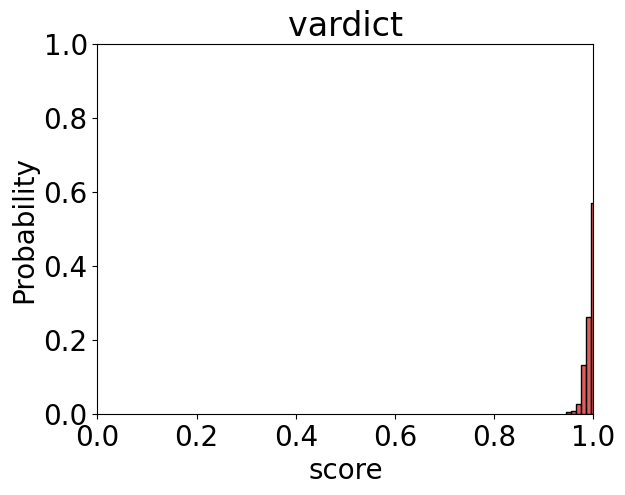

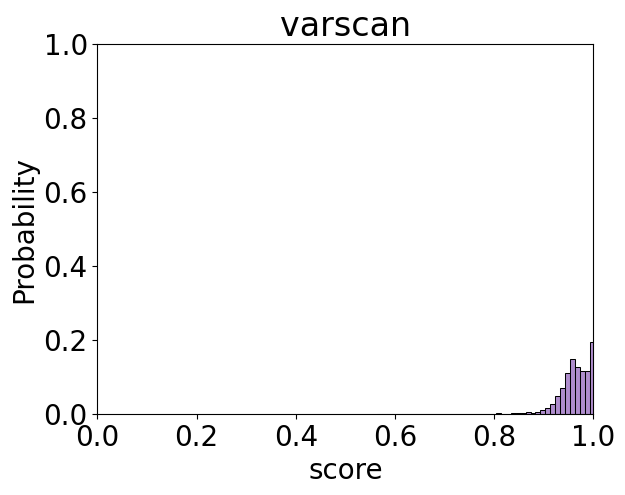

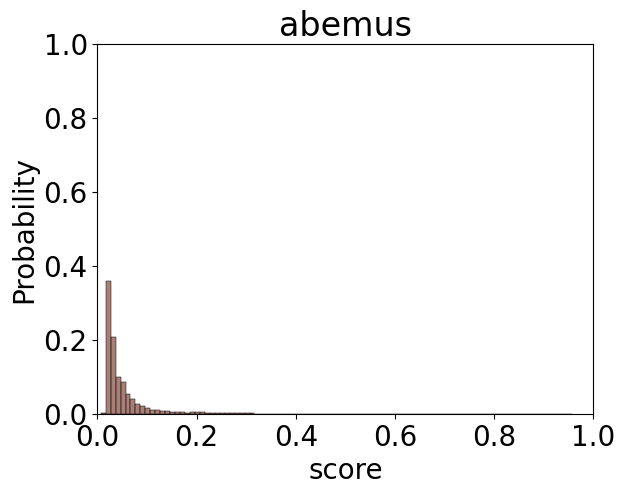

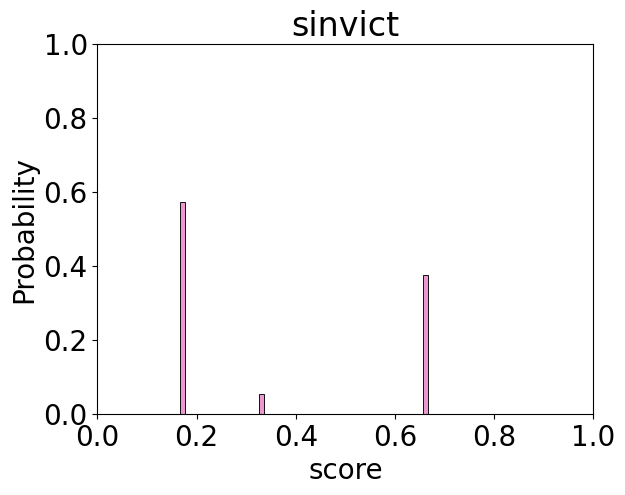

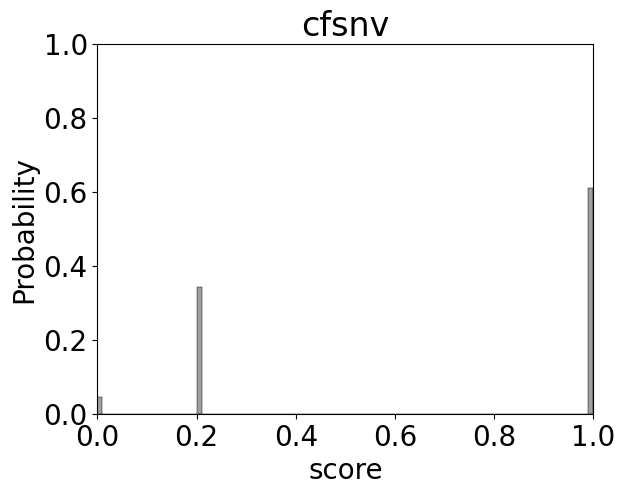

In [8]:
calltablesseries['truth'] = False
refmethods = list(np.copy(config.methods))
print(refmethods)

ncallsinundiluted = calltablesseries[['{:.2f}_{}'.format(max(calltables['tf']), m) for m in refmethods]].sum(axis=0)
callsinundiluted = calltablesseries[['{:.2f}_{}_score'.format(max(calltables['tf']), m) for m in refmethods]]
print(ncallsinundiluted)
callsinundiluted.columns = refmethods
callsinundiluted = callsinundiluted.stack().reset_index(level=0, drop=False).reset_index()
callsinundiluted.set_index('chrom_pos_ref_alt', inplace=True)
callsinundiluted.columns = ['method', 'score']
for mi, m in enumerate(refmethods):
    plt.figure()
    sns.histplot(callsinundiluted[callsinundiluted['method'] == m], x='score', stat="probability", color=config.colors[config.methods.index(m)], binwidth=0.01)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.title(m)

# pseudo ground truth = mutations found by at least k callers
if muttype == 'snv':
    nref = 5
elif muttype == 'indel':
    nref = 3
truthpos = list(calltablesseries[calltablesseries[['{:.2f}_{}'.format(max(calltables['tf']), m) for m in refmethods]].sum(axis=1) >= nref].index)
calltablesseries.loc[truthpos, 'truth'] = True
calltablesseries['truth'].value_counts()

## Approach 2: rank mutations

45.45_freebayes     4034
45.45_mutect2      11073
45.45_strelka2     45060
45.45_vardict      35005
45.45_varscan      15318
45.45_abemus       22659
45.45_sinvict      30389
45.45_cfsnv          172
dtype: object
45.45_freebayes     4034
45.45_mutect2      11073
45.45_strelka2     45060
45.45_vardict      35005
45.45_varscan      15318
45.45_abemus       22659
45.45_sinvict      30389
45.45_cfsnv          172
dtype: object
(8,)
45.45_freebayes    0.042638
45.45_mutect2      0.015533
45.45_strelka2     0.003817
45.45_vardict      0.004914
45.45_varscan      0.011229
45.45_abemus       0.007591
45.45_sinvict       0.00566
45.45_cfsnv             1.0
dtype: object
count    307109.000000
mean          0.000220
std           0.002452
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000030
max           0.134997
Name: score, dtype: float64
(102, 9)


,45.45_freebayes_score,45.45_mutect2_score,45.45_strelka2_score,45.45_vardict_score,45.45_varscan_score,45.45_abemus_score,45.45_sinvict_score,45.45_cfsnv_score,score
chrom_pos_ref_alt,,,,,,,,,
22_16050159_C_T,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
22_16050252_A_T,0.0,0.0,0.0,0.000000,0.000000,0.0,0.002516,0.0,0.000314
22_16050408_T_C,0.0,0.0,0.0,0.000000,0.000000,0.0,0.002516,0.0,0.000314
22_16050455_T_C,0.0,0.0,0.0,0.000903,0.009451,0.0,0.000157,0.0,0.001314
22_16050612_C_G,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000157,0.0,0.000020


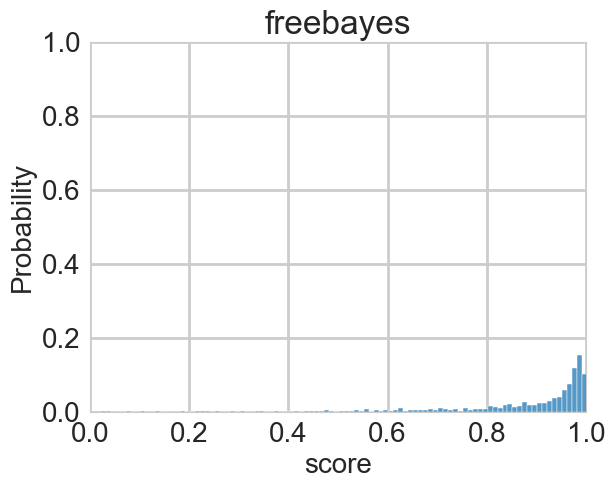

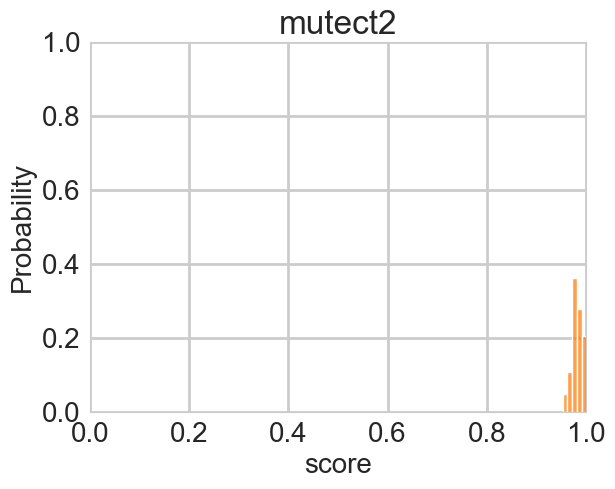

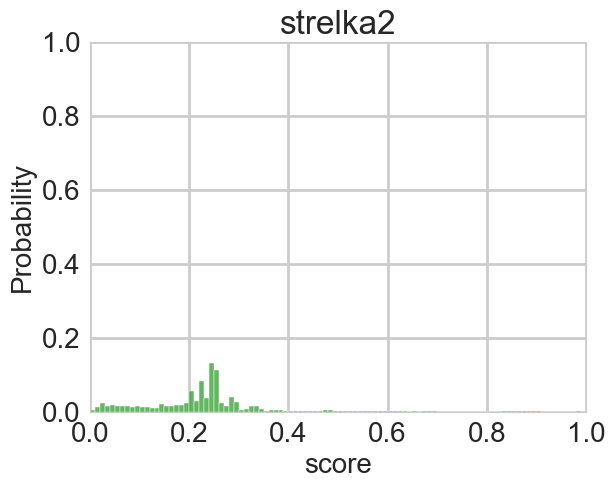

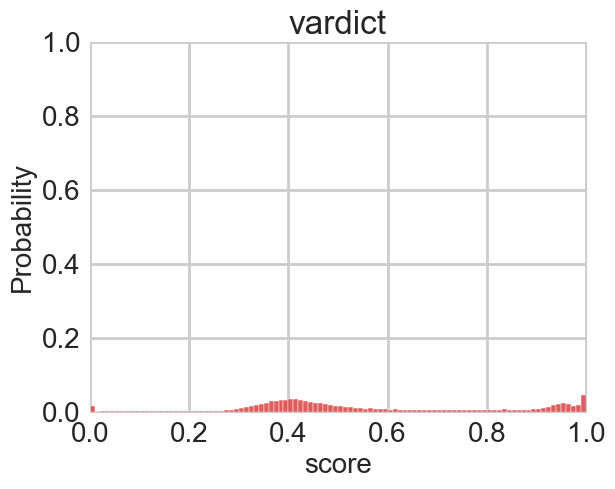

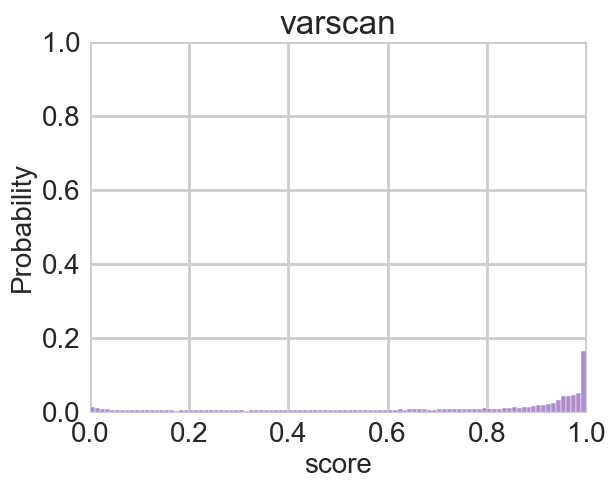

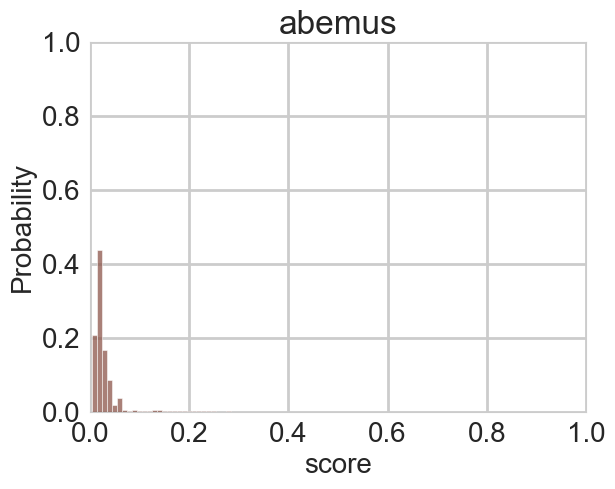

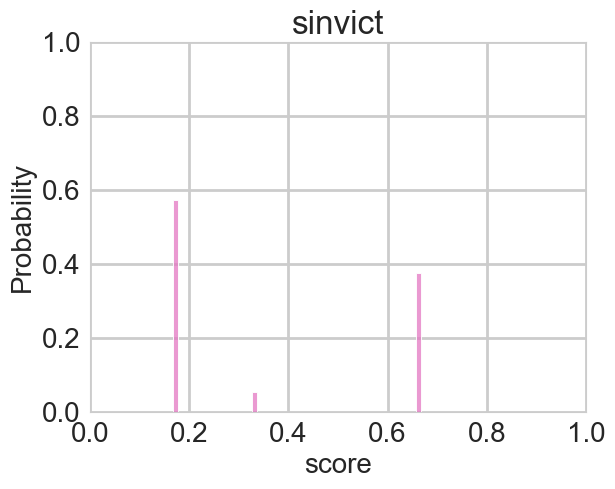

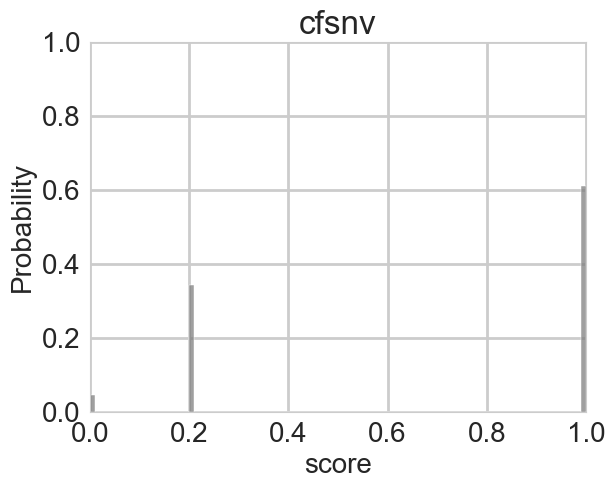

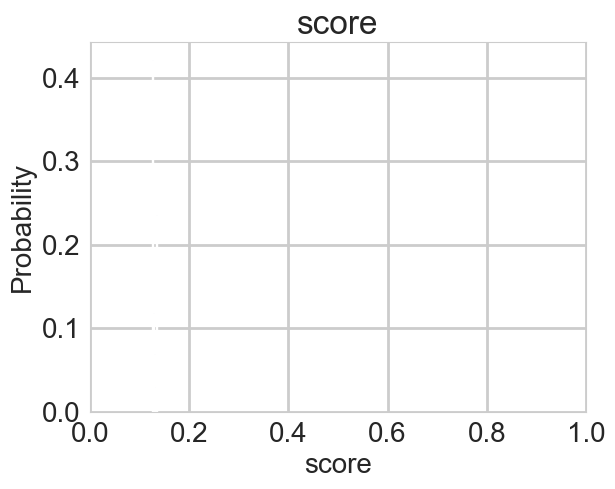

In [75]:
#calltablesseries['truth'] = False

if muttype == 'snv':
    refmethods = config.methods
elif muttype == 'indel':
    refmethods = list(np.copy(config.methods))
    refmethods.remove('abemus')
    refmethods.remove('cfsnv')
    

# pseudo ground truth = best K mutations found by each caller
# number mutations found by each method
ncallsinundiluted = calltablesseries[['{:.2f}_{}'.format(max(calltables['tf']), m) for m in refmethods]].sum(axis=0)
callsinundiluted = calltablesseries[['{:.2f}_{}_score'.format(max(calltables['tf']), m) for m in refmethods]]
print(ncallsinundiluted)
callsinundiluted.columns = refmethods
callsinundiluted = callsinundiluted.stack().reset_index(level=0, drop=False).reset_index()
callsinundiluted.set_index('chrom_pos_ref_alt', inplace=True)
callsinundiluted.columns = ['method', 'score']
for mi, m in enumerate(refmethods):
    plt.figure()
    sns.histplot(callsinundiluted[callsinundiluted['method'] == m], x='score', stat="probability", color=config.colors[config.methods.index(m)], binwidth=0.01)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.title(m)
    
ncallsinundiluted = calltablesseries[['{:.2f}_{}'.format(max(calltables['tf']), m) for m in refmethods]].sum(axis=0)
print(ncallsinundiluted)

ncallsinundiluted = calltablesseries[['{:.2f}_{}'.format(max(calltables['tf']), m) for m in refmethods]].sum(axis=0)
ncallsinundiluted = ncallsinundiluted.max()/ncallsinundiluted
ncallsinundiluted = ncallsinundiluted/ncallsinundiluted.max()
print(ncallsinundiluted.shape)
print(ncallsinundiluted)

callsinundiluted = calltablesseries[['{:.2f}_{}_score'.format(max(calltables['tf']), m) for m in refmethods]]
callsinundiluted.sort_values(by=list(callsinundiluted.columns), ascending=False).head()
#callsinundiluted.head()

for c in callsinundiluted.columns:
    callsinundiluted[c] *= callsinundiluted[c] * ncallsinundiluted.loc[c[:-6]]
callsinundiluted = callsinundiluted.fillna(0)
callsinundiluted['score'] = callsinundiluted[['{:.2f}_{}_score'.format(max(calltables['tf']), m) for m in refmethods]].sum(axis=1) / len(refmethods)
print(callsinundiluted['score'].describe())

print(callsinundiluted[callsinundiluted['score'] > 1/(len(refmethods))].shape)

plt.figure()
sns.histplot(callsinundiluted[callsinundiluted['score'] > 1/(len(refmethods))], x='score', stat='probability', bins=10)
plt.xlim([0,1])
plt.title('score')

callsinundiluted.head()

In [76]:
calltablesseries['truth'] = False
callsinundiluted[callsinundiluted['score'] > 1/(len(config.methods))]
truthpos = list(callsinundiluted[callsinundiluted['score'] > 1/(len(config.methods))].index)
calltablesseries.loc[truthpos, 'truth'] = True

print(calltablesseries[calltablesseries['truth'] == True][['{:.2f}_{}'.format(max(calltables['tf']), m) for m in config.methods]].sum(axis=1).value_counts())

calltablesseries['truth'].value_counts()

3.0    26
2.0    21
7.0    20
5.0    10
6.0    10
8.0     8
4.0     7
dtype: int64


False    307007
True        102
Name: truth, dtype: int64

# Plots

0.0006641932735335753


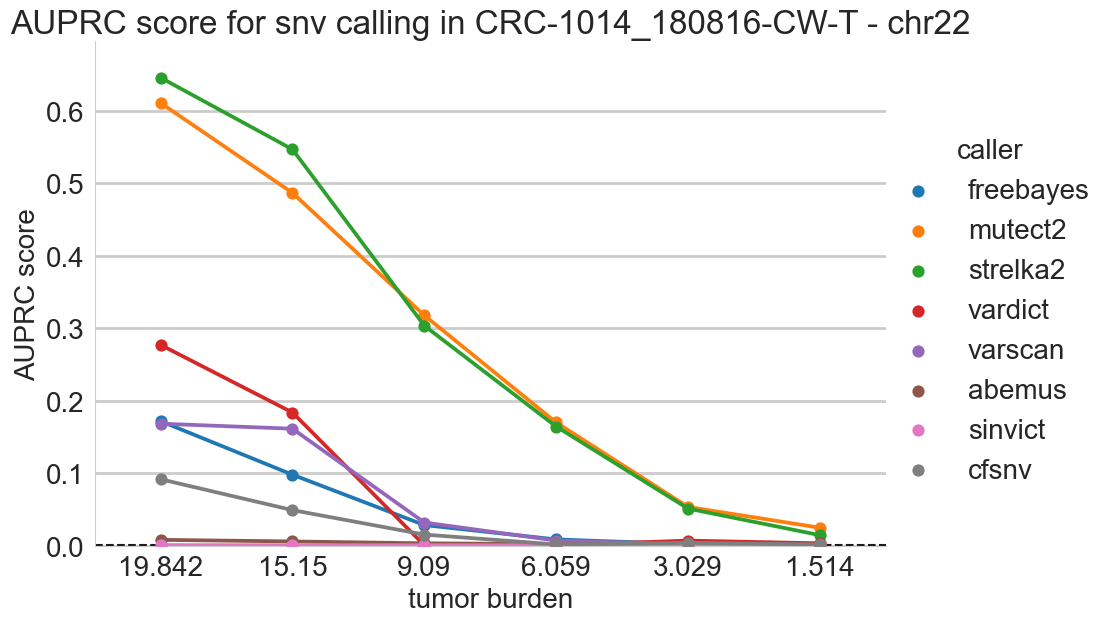

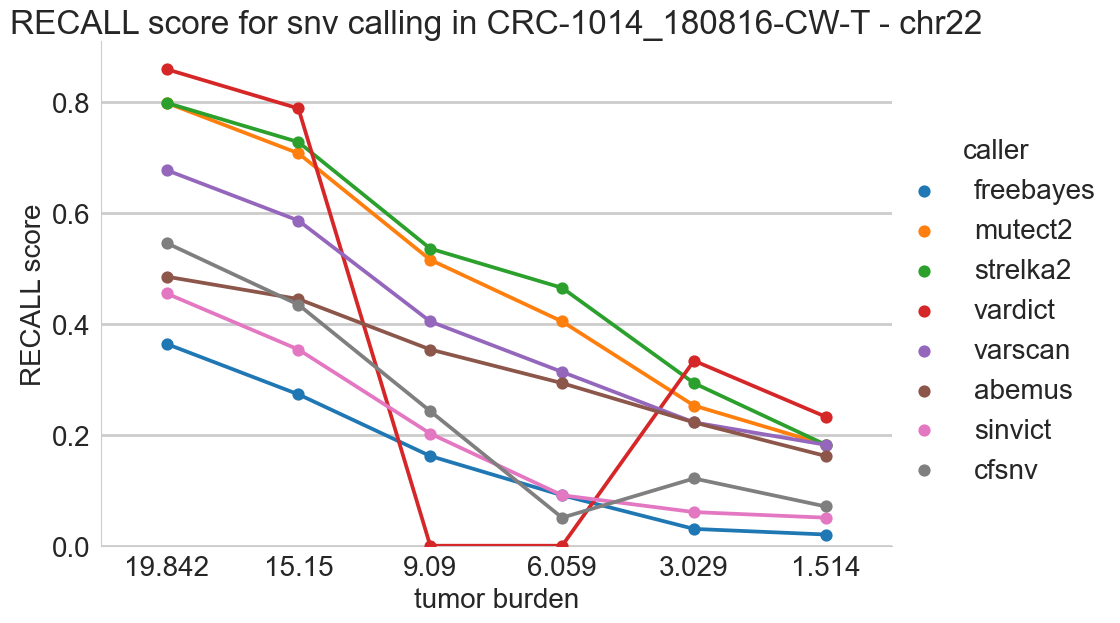

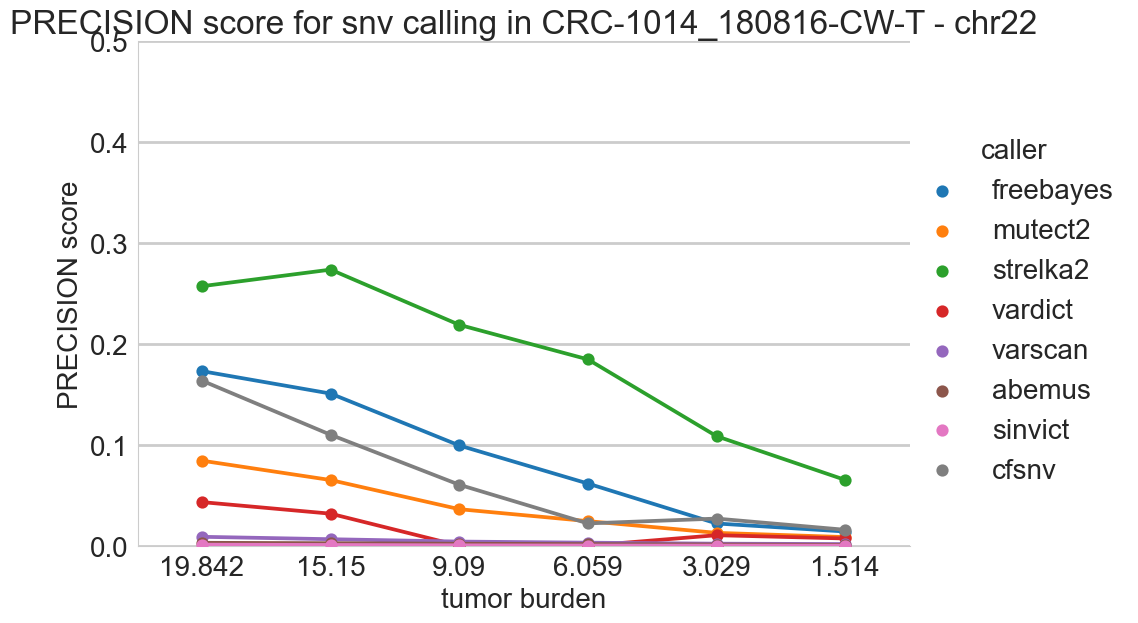

In [9]:
if fixedvar == 'coverage':
    dilutionseries = [(70,0), (70, 80), (50, 100), (30, 120), (20, 130), (10, 140), (5, 145)]
elif fixedvar == 'ctdna':
    dilutionseries = [(70,0), (70, 30), (70, 80), (70, 130), (70, 180)]

results_auprc_df = metric_curve(config, calltablesseries, plasmasample, healthysample, dilutionseries,
                                    metric='auprc', ground_truth_method='ranked', refsample='undiluted', muttype=muttype, chrom=chrom, methods=config.methods, fixedvar=fixedvar, save=save)
results_recall_df = metric_curve(config, calltablesseries, plasmasample, healthysample, dilutionseries,
                                    metric='recall', ground_truth_method='ranked', refsample='undiluted', muttype=muttype, chrom=chrom, methods=config.methods, fixedvar=fixedvar, save=save)
results_precision_df = metric_curve(config, calltablesseries, plasmasample, healthysample, dilutionseries,
                                    metric='precision', ground_truth_method='ranked', refsample='undiluted', muttype=muttype, chrom=chrom, methods=config.methods, fixedvar=fixedvar, save=save)


{'(70, 0)': 0.4544999838652425}
{'(70, 0)': 0.4544999838652425, '(70, 80)': 0.1984150183735871}
{'(70, 0)': 0.4544999838652425, '(70, 80)': 0.1984150183735871, '(50, 100)': 0.15150498907244456}
{'(70, 0)': 0.4544999838652425, '(70, 80)': 0.1984150183735871, '(50, 100)': 0.15150498907244456, '(30, 120)': 0.09090012034496668}
{'(70, 0)': 0.4544999838652425, '(70, 80)': 0.1984150183735871, '(50, 100)': 0.15150498907244456, '(30, 120)': 0.09090012034496668, '(20, 130)': 0.060589513099624355}
{'(70, 0)': 0.4544999838652425, '(70, 80)': 0.1984150183735871, '(50, 100)': 0.15150498907244456, '(30, 120)': 0.09090012034496668, '(20, 130)': 0.060589513099624355, '(10, 140)': 0.03029403940305354}
{'(70, 0)': 0.4544999838652425, '(70, 80)': 0.1984150183735871, '(50, 100)': 0.15150498907244456, '(30, 120)': 0.09090012034496668, '(20, 130)': 0.060589513099624355, '(10, 140)': 0.03029403940305354, '(5, 145)': 0.015137110054737347}
45.45_freebayes_score
19.84_freebayes_score
15.15_freebayes_score
9.09_

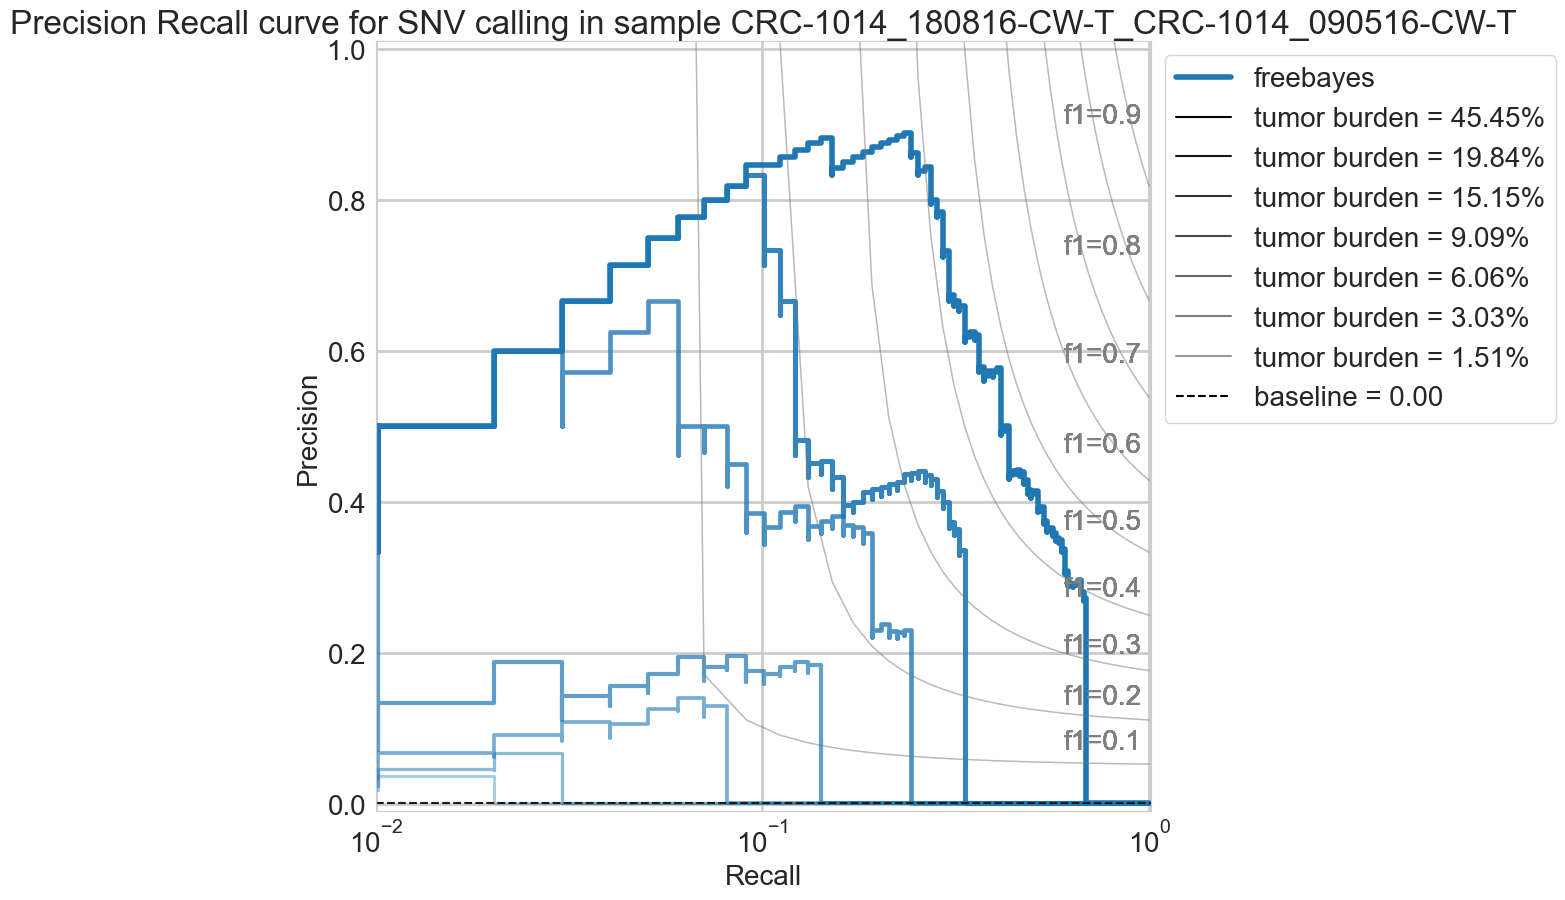

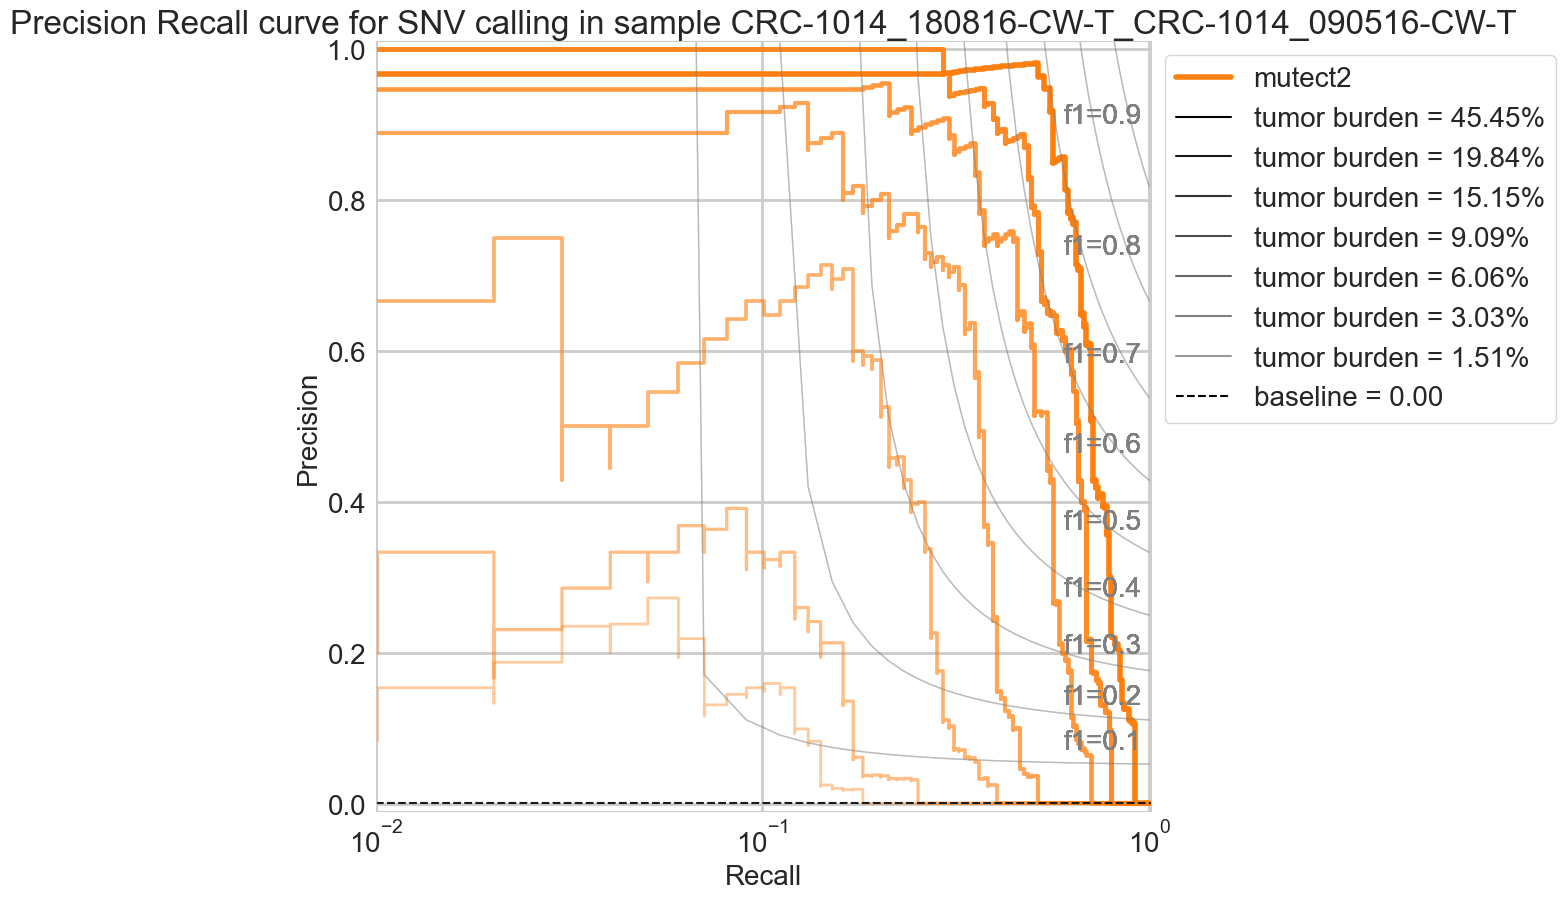

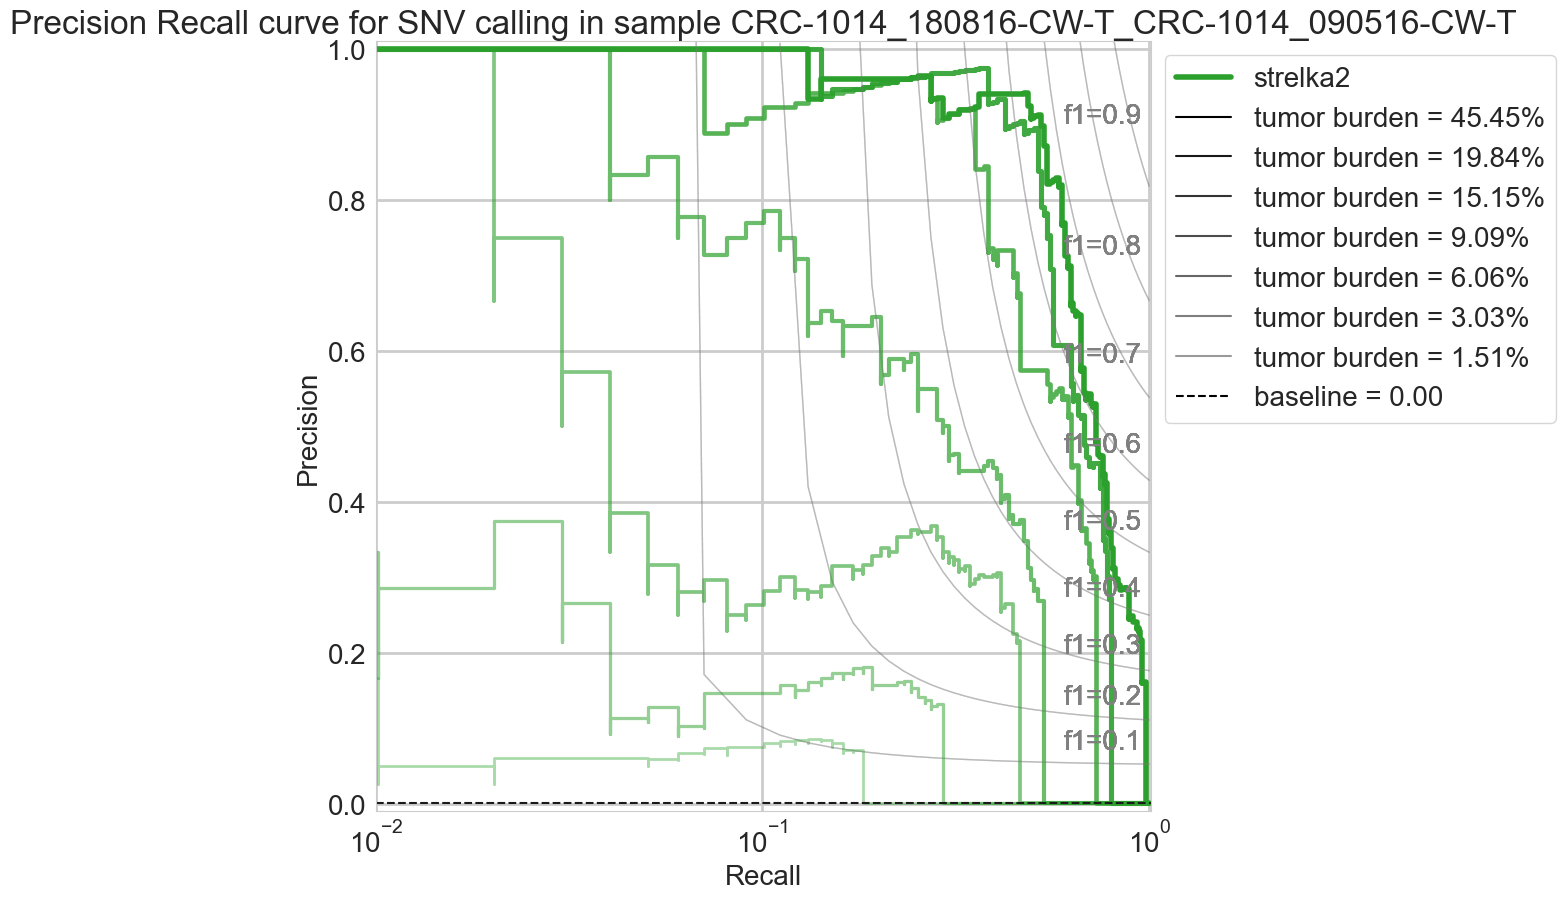

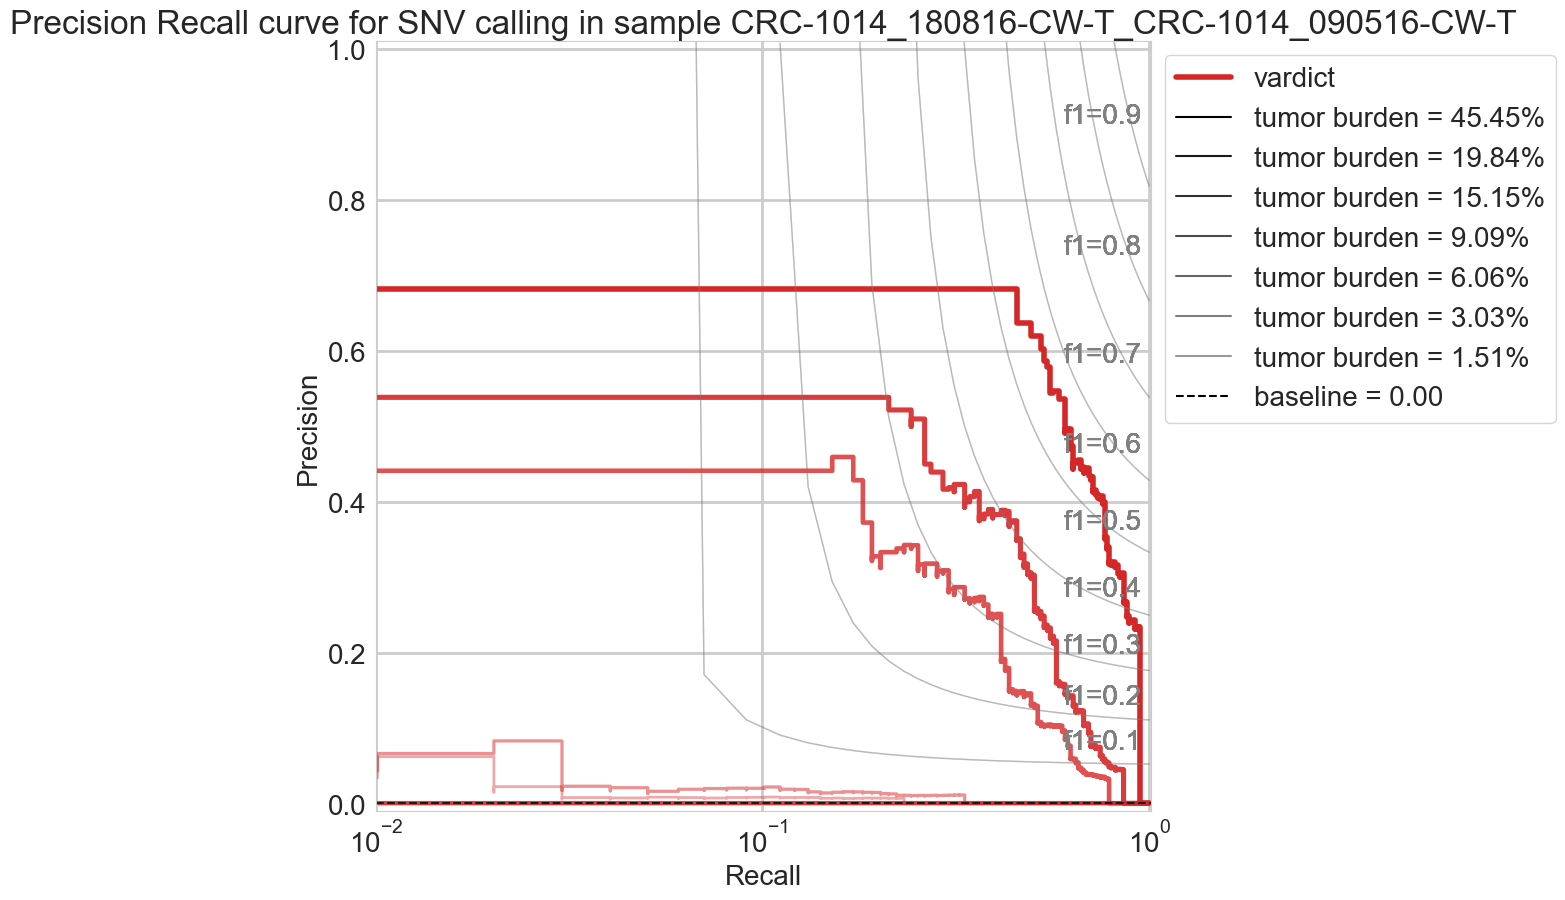

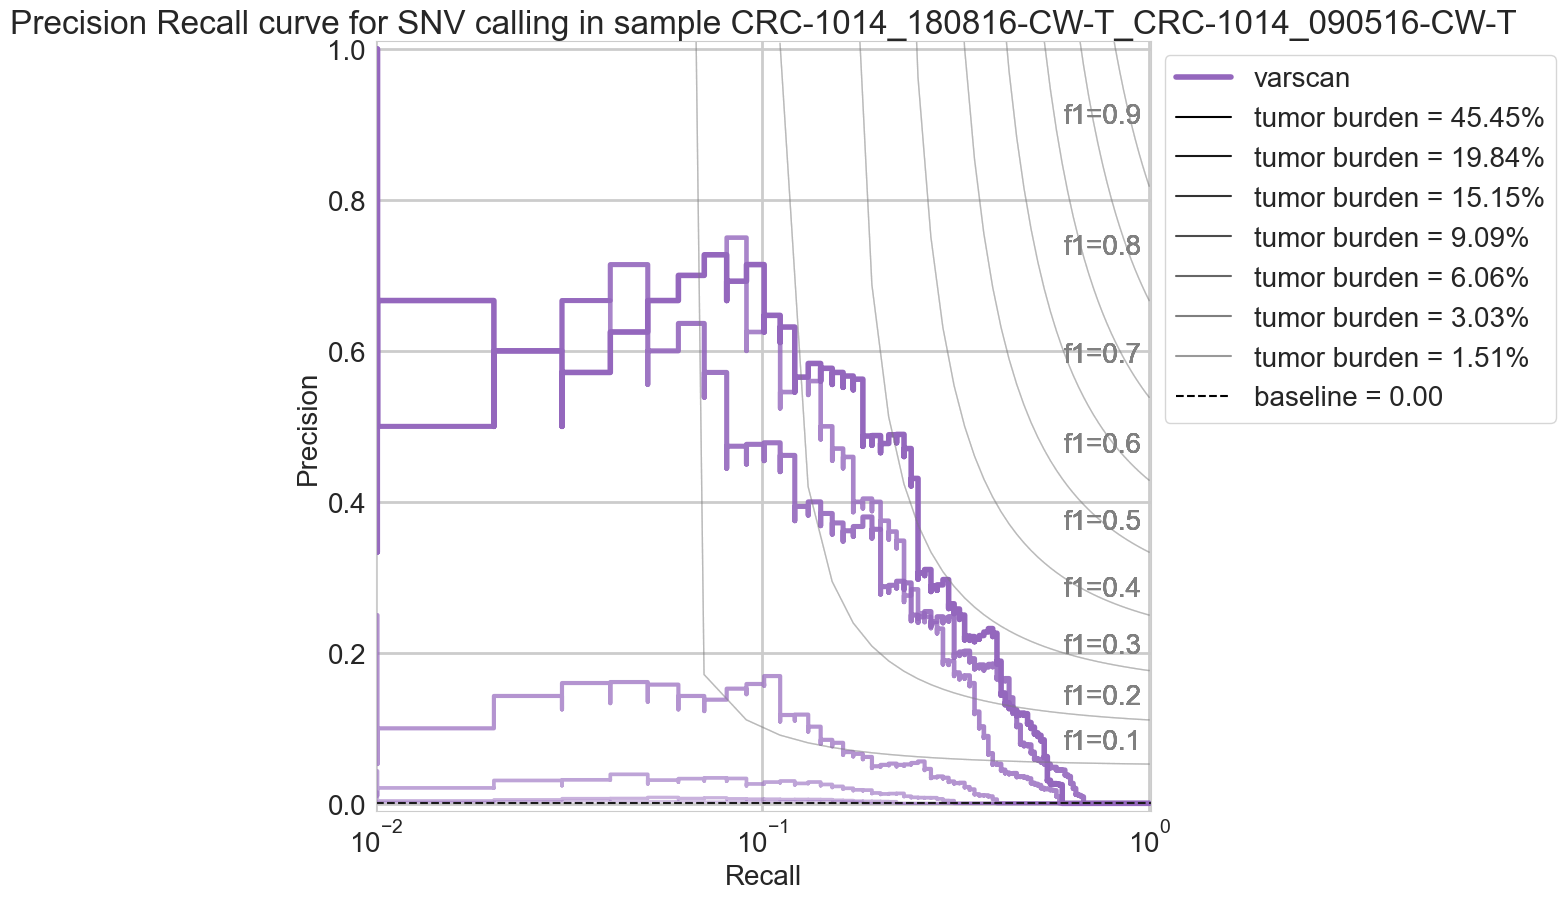

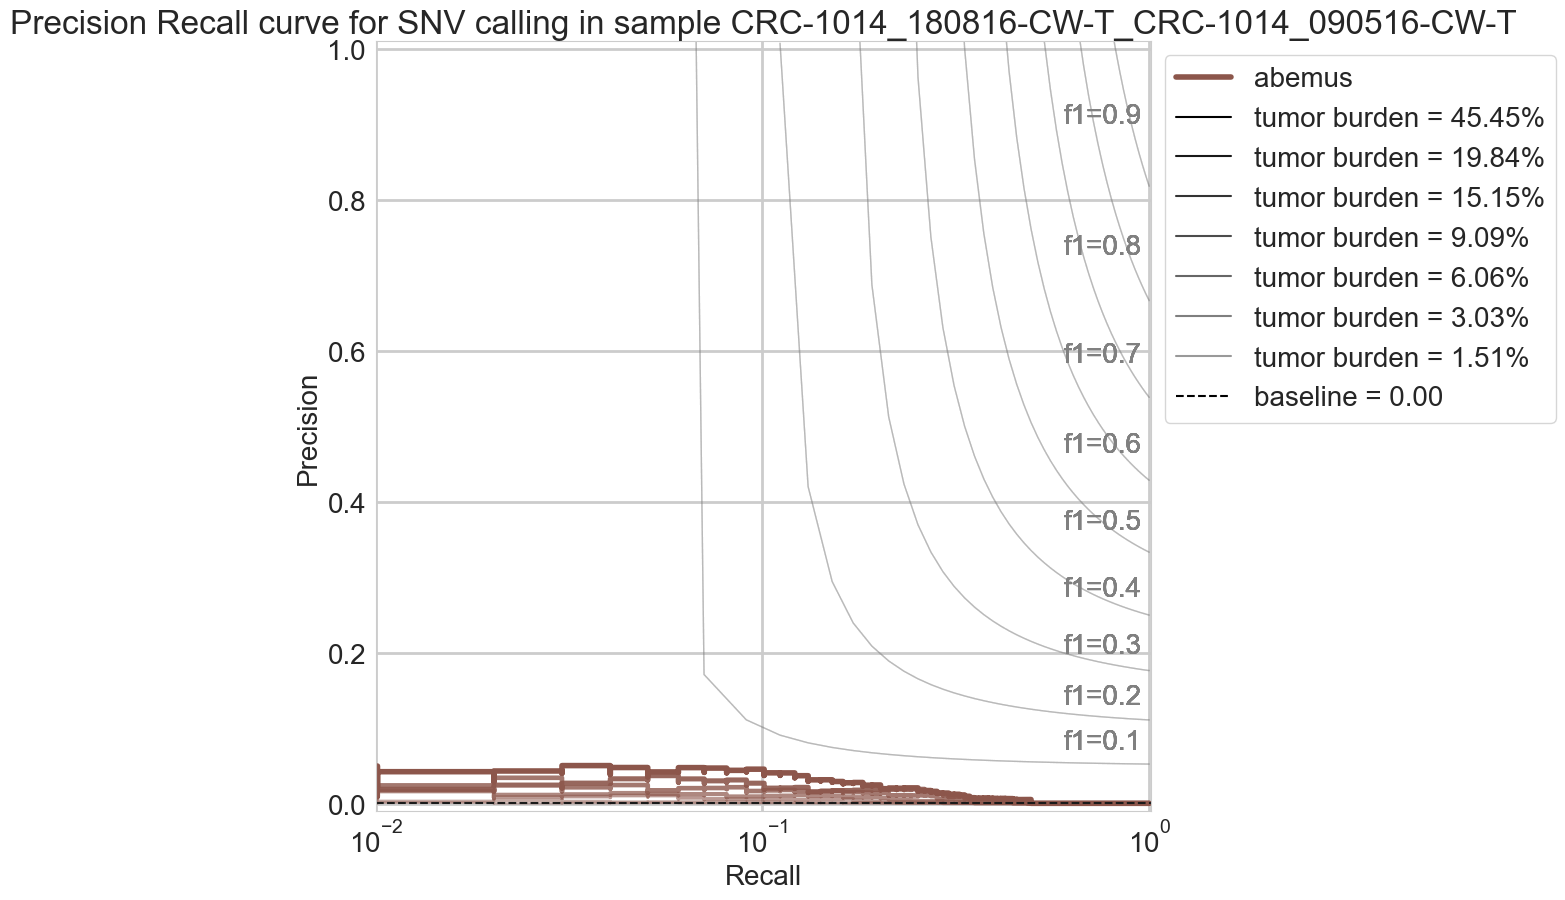

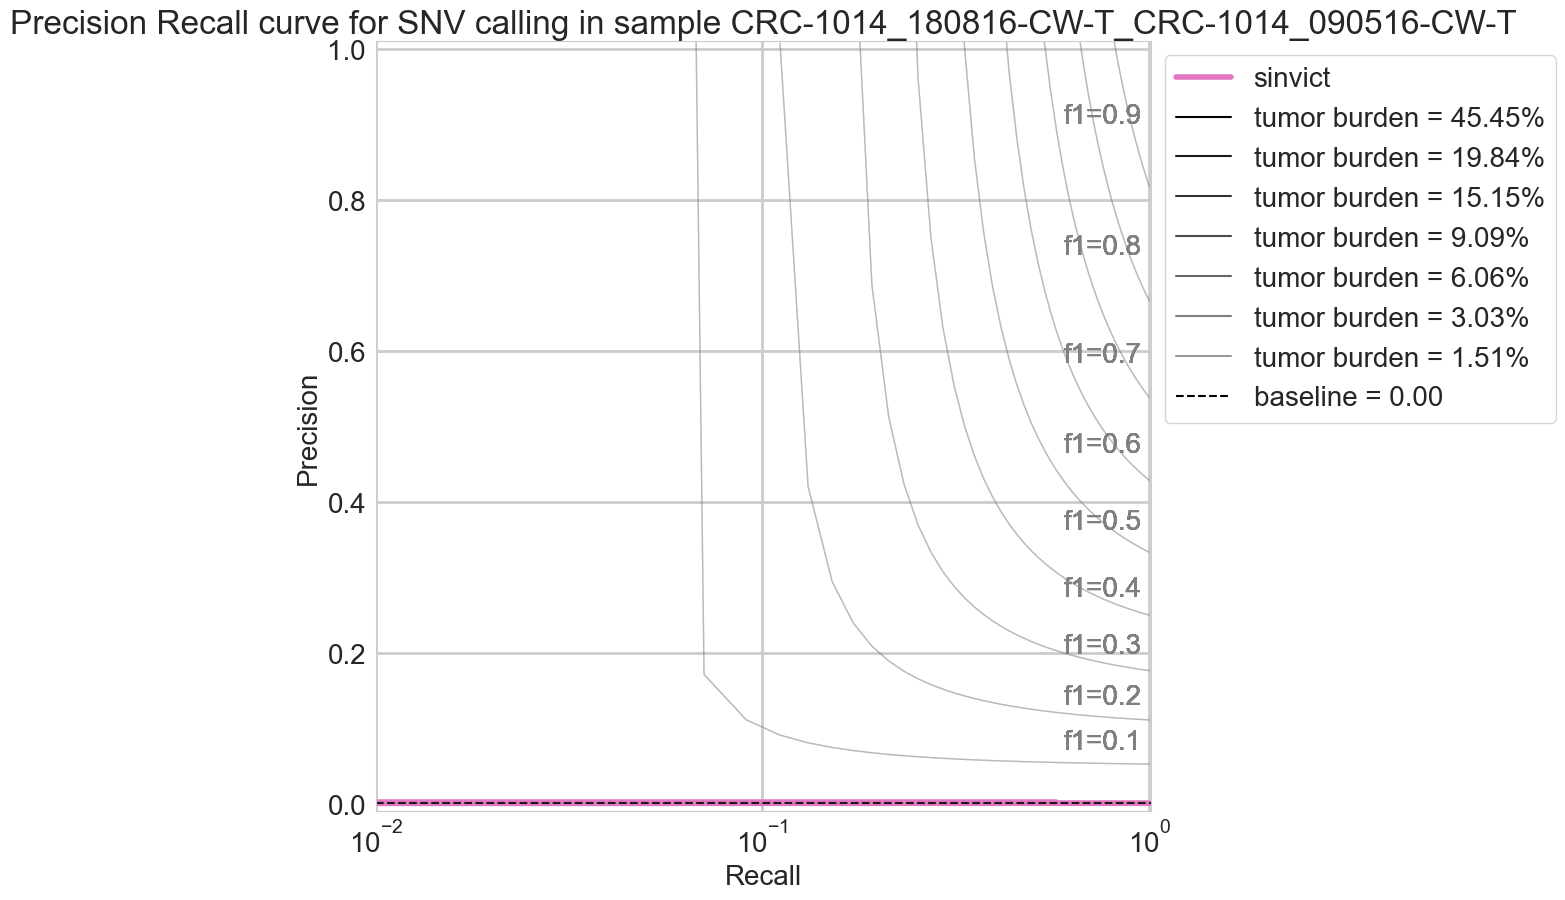

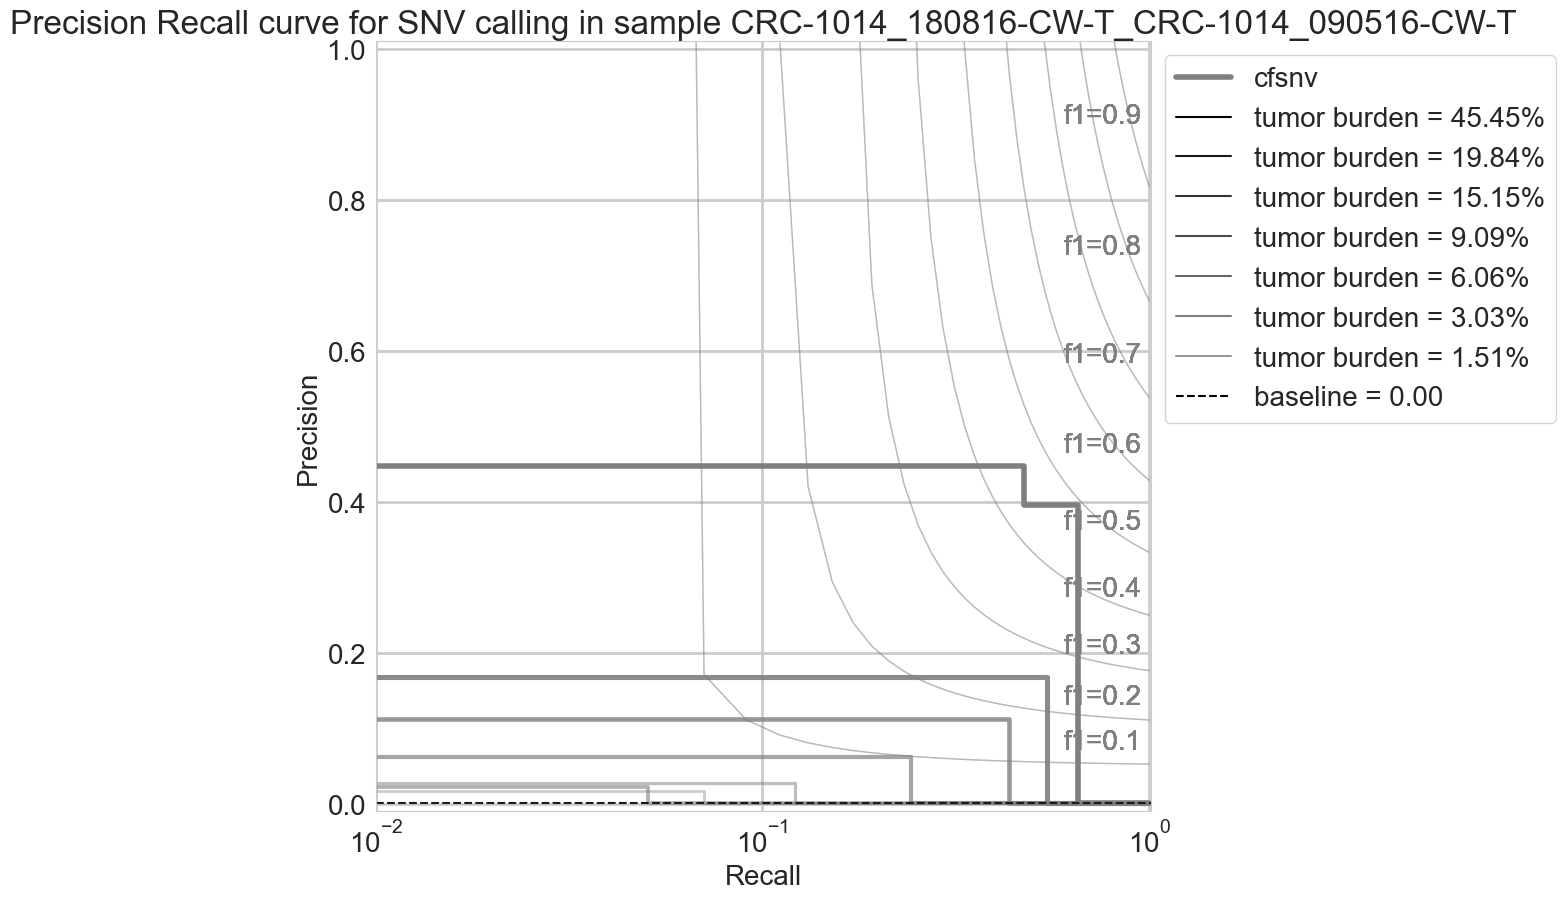

In [10]:
figure_curve(config, calltablesseries, plasmasample, healthysample, dilutionseries, xy='pr', ground_truth_method='ranked',
             refsample='undiluted', muttype=muttype.upper(), chrom='22', methods=None, fixedvar=fixedvar, save=save)

# Confusion matrix

# Call set similarity: Jaccard Index

In [ ]:

for sklearn.metrics.jaccard_similarity_score(y_true, y_pred, normalize=True)

# Change in prediction with dilution

# True Positive, False Negative and False Positive Mutations

# Stacked TP, FN, FP, TN

# Number of mutations

# Ratio performance attenuation